
# Periodic Star Modulation Fit

This metric was written by Nina Hernitschek (nina.hernitschek@vanderbilt.edu) to evaluate the feasibility of recovering light-curve modulation in RR Lyrae stars, such as caused by the Blazhko effect.  
While the primary purpose is studying the detection of the Blazhko effect, this metric not solely aims at that purpose, but at evaluating variable star light curves from short time intervals in general. 

Original notebook here: https://github.com/ninahernitschek/LSST_cadencenote/blob/main/periodicStarModulationFit_RRLyrae_halo.ipynb 
by Nina Hernitschek ((nina.hernitschek@vanderbilt.edu), 



In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import healpy as hp
import pandas as pd

import rubin_sim.maf as maf
from rubin_sim.data import get_baseline

In [2]:
# Baseline Survey
baseline_file = get_baseline()
runName = os.path.split(baseline_file)[-1].replace('.db', '')

print(runName)

baseline_v2.1_10yrs


In [3]:
# Set up output
outDir = 'rrLyrae'
resultsDb = maf.db.ResultsDb(out_dir=outDir)

The magnitudes and amplitudes for RR Lyrae in this metric evaluation are set to 0.3 (days) and 0.3 (magnitudes), however we will evaluate two different populations with different colors. 

In [4]:
#Typical periods and amplitude for type c RR Lyrae
#RP_RRc = {0.3,0.32,0.35}
#RA_RRc = {0.3,0.3,0.27}
#compute absolute magnitudes in ugrizy of RRc from OGLE observations in Magellanic Clouds 
#(and we assume 18.5 and 0.08 for the distance modulus and reddening of LMC ).

# colors for c type RRLyrae
I_rrc_lmc = 18.9
V_rrc_lmc = 19.2
Vi = V_rrc_lmc - (2.742 * 0.08) - 18.5   
Ii = I_rrc_lmc - (1.505 * 0.08) - 18.5

ii_rrc = Ii + 0.386*0.013 + 0.397  # 0.013 = (i-z)_0
gi_rrc = ii_rrc+ 1.481*(Vi-Ii) - 0.536
ri_rrc = (1/0.565) * (Vi-0.435*gi_rrc + 0.016)
ui_rrc = gi_rrc + 0.575
zi_rrc = ii_rrc - 0.013
yi_rrc = zi_rrc

#Recovery of RRa
I_RRab_lmc = 18.9
V_RRab_lmc = 19.4

Vi = V_RRab_lmc - (2.742 * 0.08) - 18.5   
Ii = I_RRab_lmc - (1.505 * 0.08) - 18.5

ii_rrab = Ii + 0.386*0.013 + 0.397  # 0.013 = (i-z)_0
gi_rrab = Ii+ 1.481*(Vi-Ii) - 0.536
ri_rrab = (1/0.565) * (Vi-0.435*gi_rrab + 0.016)
ui_rrab = ri_rrab + 0.575
zi_rrab = Ii - 0.013
yi_rrab = zi_rrab

dm = 18.5

rrc = np.array([ui_rrc, gi_rrc, ri_rrc, ii_rrc, zi_rrc, yi_rrc])
rrab = np.array([ui_rrab, gi_rrab, ri_rrab, ii_rrab, zi_rrab, yi_rrab])
print(rrc+dm)
print(rrab+dm)

[19.51835824 18.94335824 19.03766224 19.181618   19.168618   19.168618  ]
[20.04811504 18.83754024 19.47311504 19.181618   18.7666     18.7666    ]


In [5]:
#  Set up to time it at one point in the sky

time_interval = 20
dM = 19.0
summaryStats = [maf.MeanMetric(), maf.MedianMetric(), maf.MaxMetric()]

metricC = maf.PeriodicStarModulationMetric(period=0.3, amplitude=0.3, random_phase=True,
                                          time_interval=time_interval,
                                          n_monte=100, period_tol=0.002, amp_tol=0.01, 
                                          means=rrc+dM,
                                          mag_tol=0.01, n_bands=3)
slicer = maf.HealpixSlicer(nside=8)
sql = 'night < 365*2'

bundleC = maf.MetricBundle(metricC, slicer, sql, 
                                    run_name=runName, summary_metrics=summaryStats,
                                    info_label=f'dm {dM} interval {time_interval} RRc')

bg =  maf.MetricBundleGroup({'RRc': bundleC}, baseline_file,
                             out_dir=outDir, results_db=resultsDb)

# Behind the scenes stuff to get the simulated data and set up the slicer so we can test ONE point
bg.set_current(sql)
bg.get_data(sql)
simData = bg.sim_data
bundleC.slicer.setup_slicer(simData)

Healpix slicer using NSIDE=8, approximate resolution 439.742261 arcminutes


In [6]:
lenvisits = []
for s in bundleC.slicer:
    lenvisits.append(len(s['idxs']))
lenvisits = np.array(lenvisits)
x = np.where(lenvisits == np.max(lenvisits))[0][0]

bundleC.slicer[x]

{'idxs': array([ 22652, 218645, 218644, ..., 383777, 258668, 258718]),
 'slice_point': {'sid': 660,
  'ra': 1.009797638653862,
  'dec': -0.8402225818983444,
  'nside': 8,
  'gall': 4.475514273828551,
  'galb': -0.8626535854534877}}

In [7]:
%%timeit 

metricC.run(simData[bundleC.slicer[x]['idxs']], bundleC.slicer[x]['slice_point'])

12.4 s ± 1.04 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [8]:
# Set a variety of time intervals - the short periods in which to evaluate each light curve
# and distance moduli, to vary the input magnitudes to be equivalent to different distances.


time_intervals = (15, 20, 30, 50) 
# Looking at cadence note output, suggests that 50 days may not show much difference with varying survey strategy
distMod = (17.0, 18.0, 19.0, 20.0, 21.0, 22.0) 
# And perhaps could drop 17 and 22 as these don't show as much variation as the in-betwen values either

time_intervals = (15, 20, 30)
distMod = (18, 19, 20,  21)


time_intervals = [20]
distMod = [19]


Healpix slicer using NSIDE=8, approximate resolution 439.742261 arcminutes
0.64 hours to run metric (best-guess)


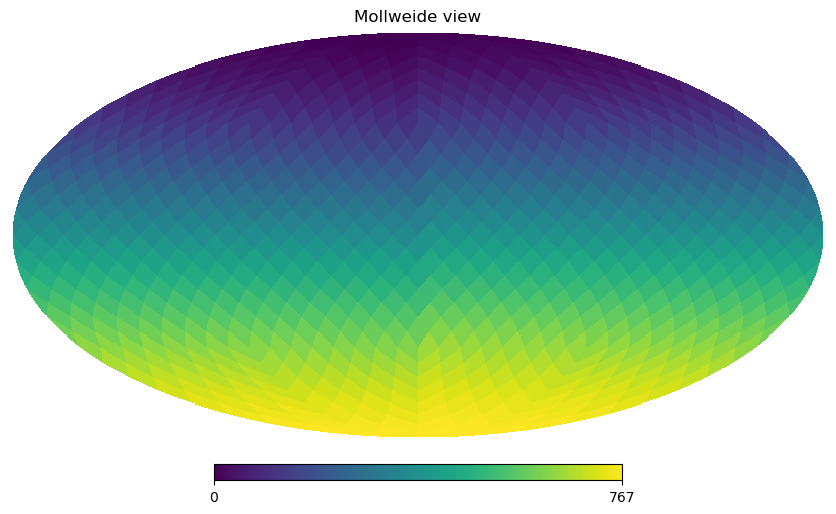

In [9]:
# And likely could refine the slice point positions - maybe (there are 768 points on the sky)
# (note that using galL/galB doesn't change the position of the healpix grid points on the sky)

slicer = maf.HealpixSlicer(nside=8)
hp.mollview(slicer.slice_points['sid'])

print(len(slicer) * len(time_intervals) * len(distMod) * 6/60/60/2, 'hours to run metric (best-guess)')

Healpix slicer using NSIDE=8, approximate resolution 439.742261 arcminutes


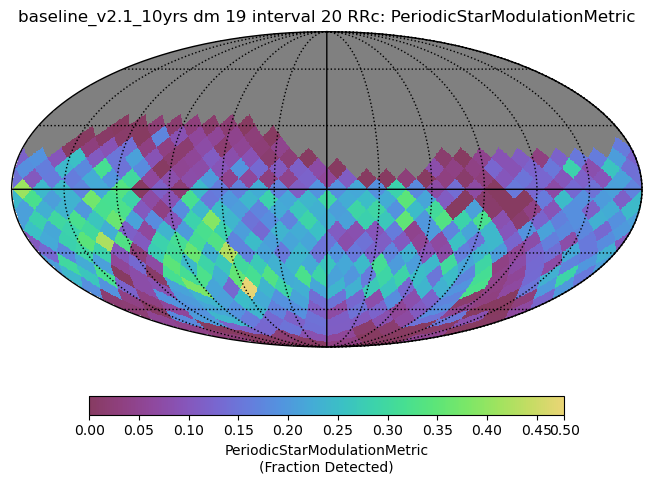

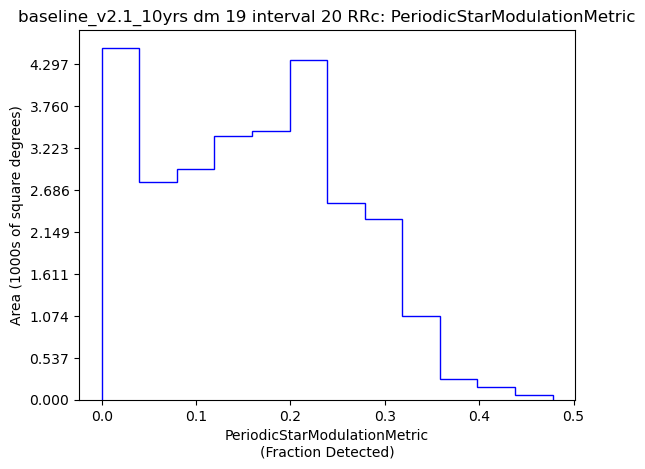

In [10]:
summaryStats = [maf.MeanMetric(), maf.MedianMetric(), maf.MaxMetric()]

bundle_list = []

for time_interval in time_intervals:
    for dM in distMod:

        metricC = maf.PeriodicStarModulationMetric(period=0.3, amplitude=0.3, random_phase=True,
                                                  time_interval=time_interval,
                                                  n_monte=100, period_tol=0.002, amp_tol=0.01, 
                                                  means=rrc+dM,
                                                  mag_tol=0.01, n_bands=3)
        metricAB = maf.PeriodicStarModulationMetric(period=0.3, amplitude=0.3, random_phase=True,
                                                  time_interval=time_interval,
                                                  n_monte=100, period_tol=0.002, amp_tol=0.01, 
                                                  means=rrab+dM,
                                                  mag_tol=0.01, n_bands=3)    
        slicer = maf.HealpixSlicer(nside=8)
        sql = 'night < 365*2'

        bundle_list.append(maf.MetricBundle(metricC, slicer, sql, 
                                            run_name=runName, summary_metrics=summaryStats,
                                            info_label=f'dm {dM} interval {time_interval} RRc'))

bd = maf.make_bundles_dict_from_list(bundle_list)
bg =  maf.MetricBundleGroup(bd, baseline_file,out_dir=outDir, results_db=resultsDb)    
bg.run_all()        
bg.plot_all(closefigs=False)

In [12]:
for b in bundle_list:
    print(b.summary_values)

{'Mean': 0.16020392644602066, 'Median': 0.16150735294117646, 'Max': 0.47777777777777775}


Healpix slicer using NSIDE=8, approximate resolution 439.742261 arcminutes


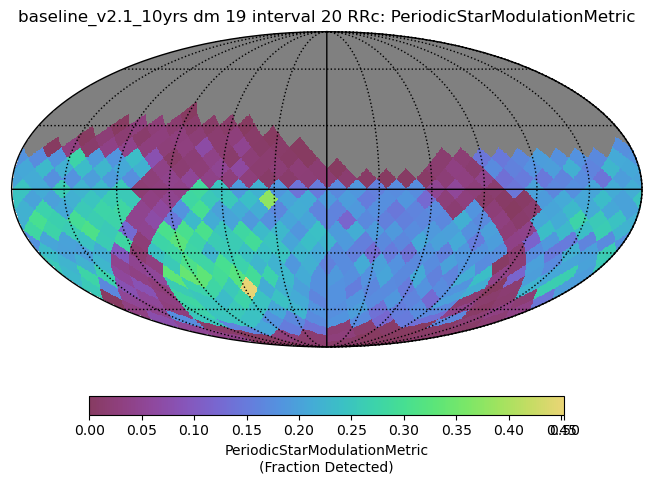

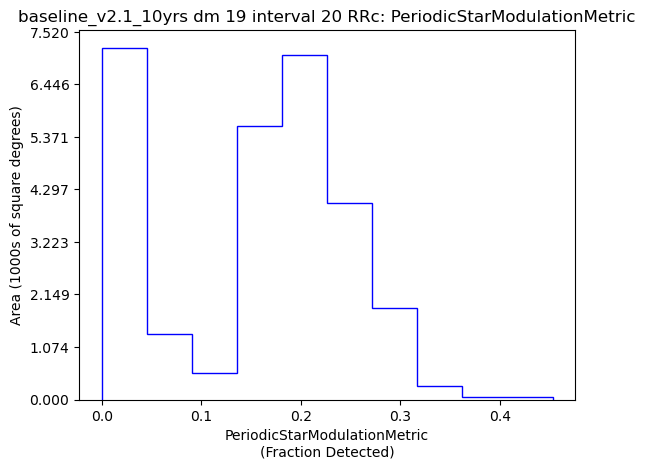

In [15]:
summaryStats = [maf.MeanMetric(), maf.MedianMetric(), maf.MaxMetric()]

bundle_list = []

for time_interval in time_intervals:
    for dM in distMod:

        metricC = maf.PeriodicStarModulationMetric(period=0.3, amplitude=0.3, random_phase=True,
                                                  time_interval=time_interval,
                                                  n_monte=100, period_tol=0.002, amp_tol=0.01, 
                                                  means=rrc+dM,
                                                  mag_tol=0.01, n_bands=3)
        metricAB = maf.PeriodicStarModulationMetric(period=0.3, amplitude=0.3, random_phase=True,
                                                  time_interval=time_interval,
                                                  n_monte=100, period_tol=0.002, amp_tol=0.01, 
                                                  means=rrab+dM,
                                                  mag_tol=0.01, n_bands=3)    
        slicer = maf.HealpixSlicer(nside=8)
        sql = ''

        bundle_list.append(maf.MetricBundle(metricC, slicer, sql, 
                                            run_name=runName, summary_metrics=summaryStats,
                                            info_label=f'dm {dM} interval {time_interval} RRc'))
bd = maf.make_bundles_dict_from_list(bundle_list)
bg =  maf.MetricBundleGroup(bd, baseline_file,out_dir=outDir, results_db=resultsDb)    
bg.run_all()        
bg.plot_all(closefigs=False)

In [16]:
for b in bundle_list:
    print(b.summary_values)

{'Mean': 0.1538180572961859, 'Median': 0.179, 'Max': 0.45292929292929296}
